In [1]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from joblib import dump, load
from sklearn.model_selection import cross_val_score
from time import localtime, strftime

# Utils

In [2]:
#CHANGE THIS
#DATA_PATH = "C:\\Users\\dluis\\.gradle\\caches\\modules-2\\files-2.1\\com.jetbrains.intellij.idea\\ideaIC\\2021.1.1\\e051d885e757b286781f50305504d7b8db3e1dba\\ideaIC-2021.1.1\\bin\\tmp\\metrics.db"
DATA_PATH = "data/metrics.db"

In [3]:
def scale_data(data, refactoring):
    scaler = StandardScaler()
    scaler.fit(data)
    dump(scaler, 'scaler' + refactoring + '.pkl')
    
    temp = scaler.transform(data)
    return pd.DataFrame(temp, columns=data.columns, index=data.index)

In [4]:
def covariance(df):
    unstack_matrix = df.corr().unstack().sort_values(ascending=False)

    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            drop = (cols[i], cols[j])
            if(drop in unstack_matrix.keys()):
                unstack_matrix.drop(drop, inplace=True)

    print(unstack_matrix[unstack_matrix > 0.9])
    print(unstack_matrix[unstack_matrix < -0.9])

In [5]:
def grid_search(data):
    X = data.values
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    model_params = {
        'OneClassSVM': {
            'model': OneClassSVM(),
            'params': {
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'nu': [0.1, 0.2, 0.3],
                'gamma': ['scale', 'auto']
            }
        },
        'IsolationForest': {
            'model': IsolationForest(),
            'params': {
                'contamination': [0.1, 0.2],
                'n_estimators': [50, 100, 200, 300, 400, 500],
                'max_samples': [100, 200, 300, 400, 500],
                'max_features': [1, 2, 3, 4, 5]
            }
        },
        'EllipticEnvelope': {
            'model': EllipticEnvelope(),
            'params': {
                'contamination': [0.01, 0.02, 0.03, 0.04, 0.05]
            }
        }
    }
    
    
    kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    y_train = [1 for i in range(len(X_train))] # 1 for inliers
    
    scores = []
    
    f2_score = make_scorer(fbeta_score, beta=2, pos_label=1)
    
    start_time = strftime("%H:%M:%S", localtime())
    
    for model_name, mp in model_params.items():
        grid_search = GridSearchCV(mp['model'],
                                    param_grid=mp['params'],
                                    return_train_score=False,
                                    cv=kf,
                                    n_jobs=-1,
                                    verbose=True,
                                     scoring=f2_score)
        grid_search.fit(X_train, y_train)
        scores.append({
            'model': model_name,
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        })
        
    print("Started at: " + start_time)
    print("Finished at: " + strftime("%H:%M:%S", localtime()))
    
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

In [6]:
def save_models(df, data, refactoring):
    one_class_svm = OneClassSVM(kernel=df.iloc[0]['best_params']['kernel'], nu=df.iloc[0]['best_params']['nu'], gamma=df.iloc[0]['best_params']['gamma'])
    isolation_forest = IsolationForest(contamination=df.iloc[1]['best_params']['contamination'], n_estimators=df.iloc[1]['best_params']['n_estimators'], max_samples=df.iloc[1]['best_params']['max_samples'], max_features=df.iloc[1]['best_params']['max_features'])
    elliptic_envelope = EllipticEnvelope(contamination=df.iloc[2]['best_params']['contamination'])
    
    X = data.values
    one_class_svm.fit(X)
    isolation_forest.fit(X)
    elliptic_envelope.fit(X)

    dump(one_class_svm, 'models/one_class_svm_' + refactoring + '.joblib')
    dump(isolation_forest, 'models/isolation_forest_' + refactoring + '.joblib')
    dump(elliptic_envelope, 'models/elliptic_envelope_' + refactoring + '.joblib')

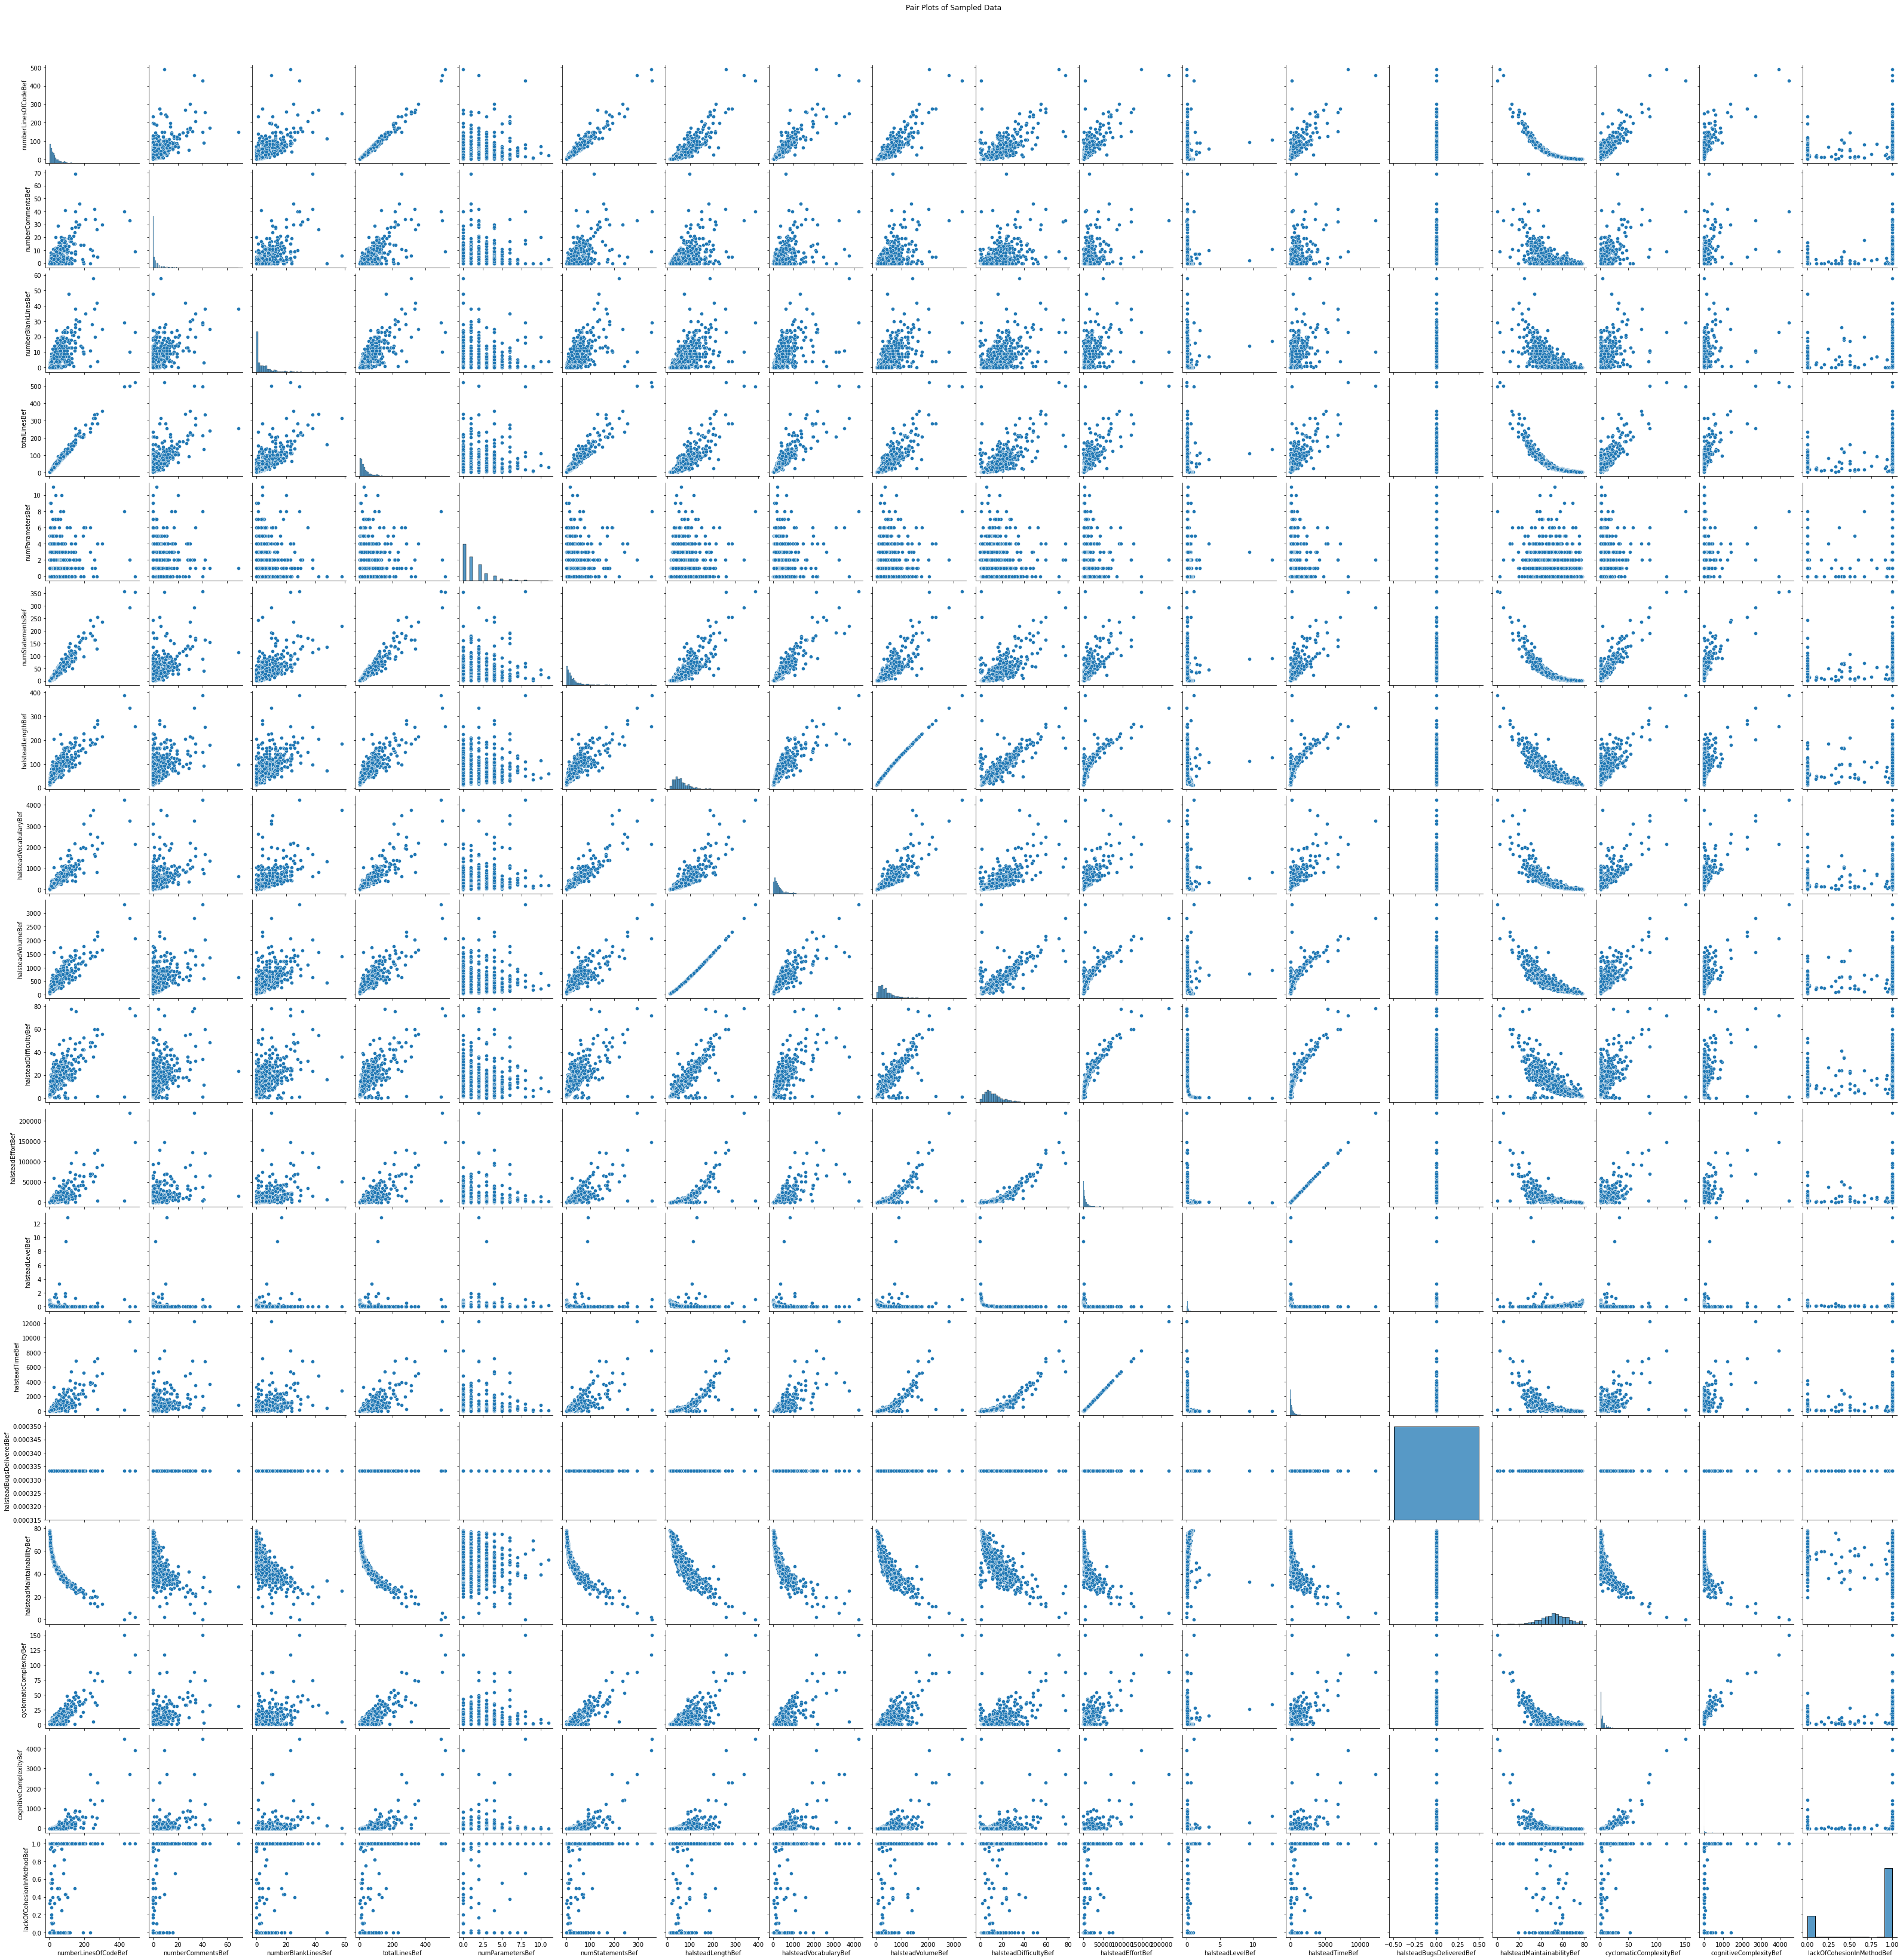

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

em_data = load_em_data(DATA_PATH)

df_sample = em_data.sample(n=1000, random_state=42)

sns.pairplot(df_sample)
plt.suptitle('Pair Plots of Sampled Data', y=1.02)
plt.show()

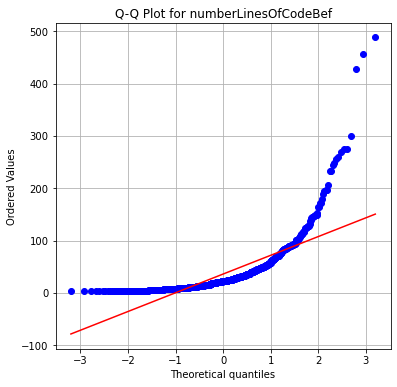

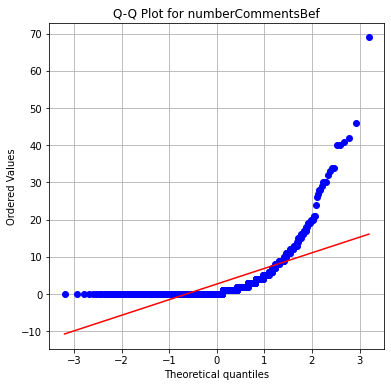

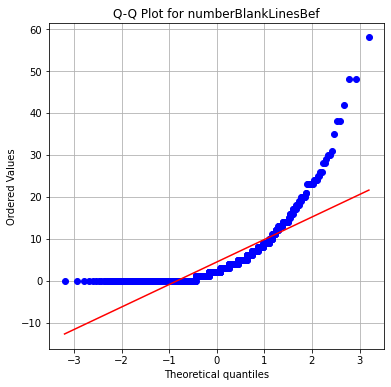

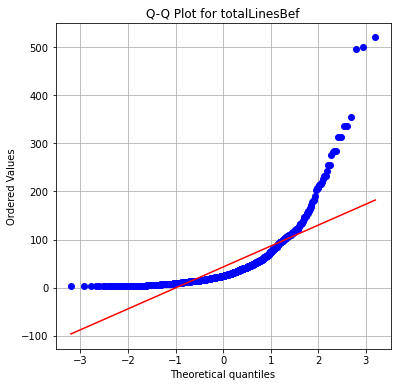

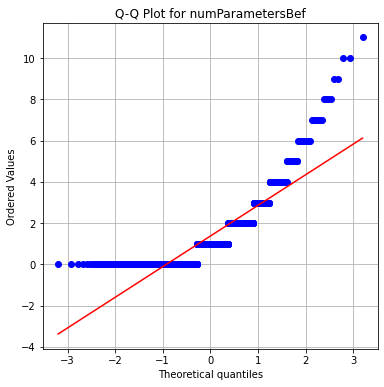

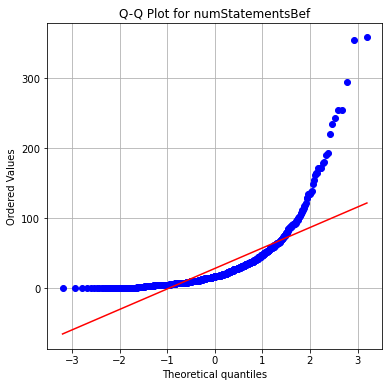

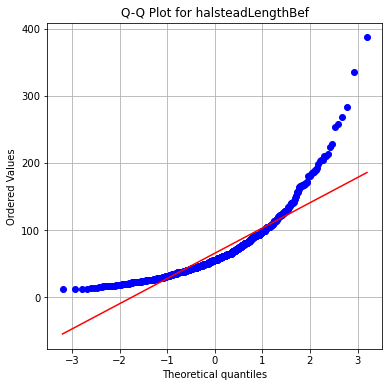

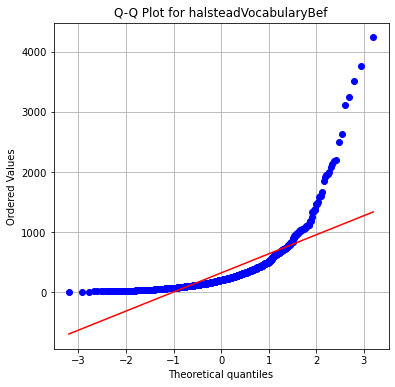

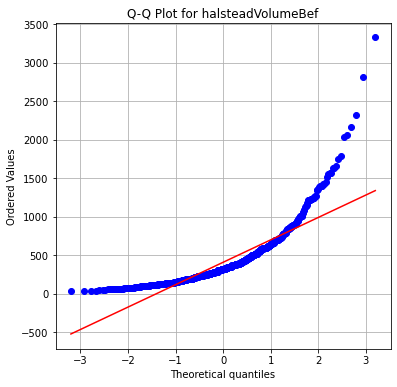

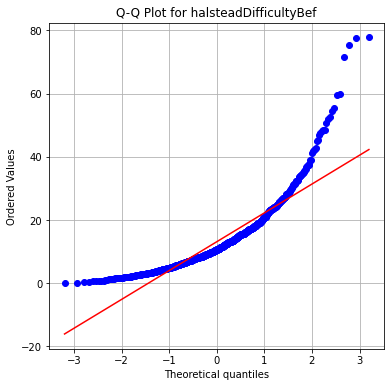

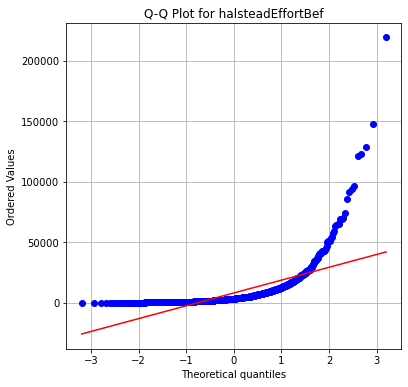

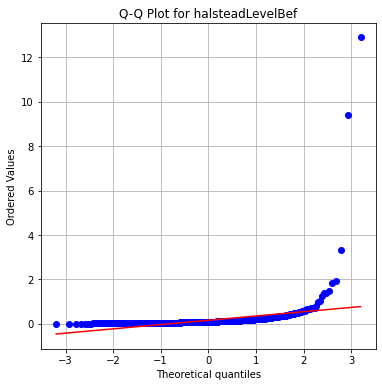

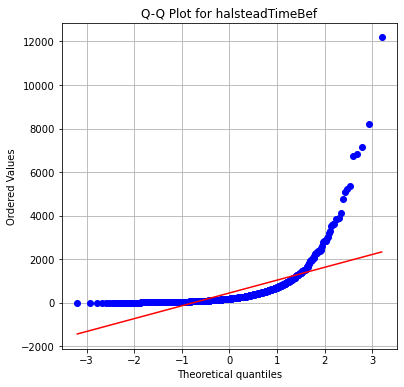

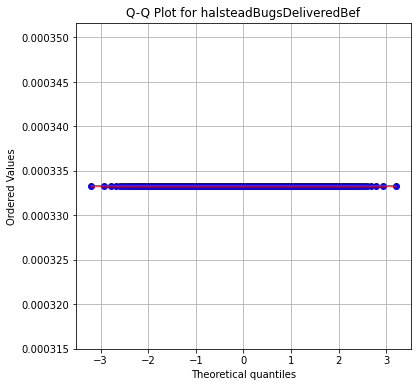

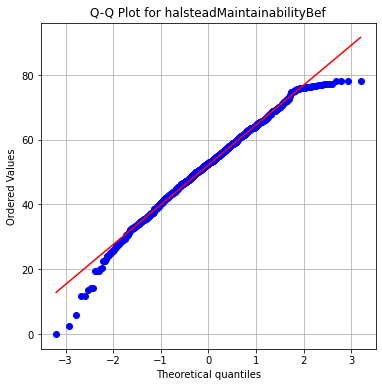

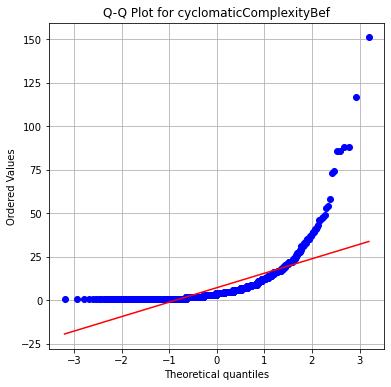

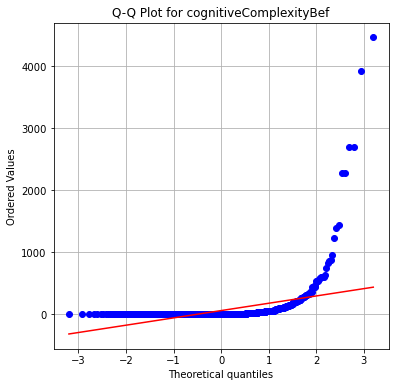

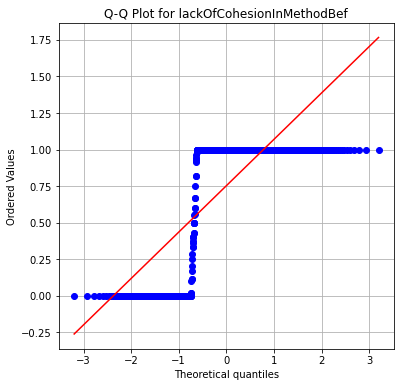

In [18]:
import scipy.stats as stats
import matplotlib.pyplot as plt

for column in df_sample.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(df_sample[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.grid()
    plt.show()

# Extract Method

In [15]:
def load_em_data(data_path):
    conn = sqlite3.connect(data_path)
    
    query = '''
            SELECT numberLinesOfCodeBef, numberCommentsBef, numberBlankLinesBef, totalLinesBef, numParametersBef,
                numStatementsBef, halsteadLengthBef, halsteadVocabularyBef, halsteadVolumeBef, halsteadDifficultyBef,
                halsteadEffortBef, halsteadLevelBef, halsteadTimeBef, halsteadBugsDeliveredBef, halsteadMaintainabilityBef,
                cyclomaticComplexityBef, cognitiveComplexityBef, lackOfCohesionInMethodBef
            FROM methodMetrics;
    '''

    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    return df

In [8]:
def delete_em_infinite_values(data_path):
    conn = sqlite3.connect(data_path)
    cursor = conn.cursor()

    cursor.execute("DELETE FROM methodMetrics WHERE CAST(halsteadLevelBef AS CHARACTER) ='Inf';")
    conn.commit()
    
    cursor.close()
    conn.close()
    
#delete_em_infinite_values(DATA_PATH)

In [9]:
em_data = load_em_data(DATA_PATH)
em_data.head()

,numberLinesOfCodeBef,numberCommentsBef,numberBlankLinesBef,totalLinesBef,numParametersBef,numStatementsBef,halsteadLengthBef,halsteadVocabularyBef,halsteadVolumeBef,halsteadDifficultyBef,halsteadEffortBef,halsteadLevelBef,halsteadTimeBef,halsteadBugsDeliveredBef,halsteadMaintainabilityBef,cyclomaticComplexityBef,cognitiveComplexityBef,lackOfCohesionInMethodBef
0,57,0,5,62,2,55,77.0,321.0,482.542564,14.721973,7103.978639,0.067926,394.665480,0.000333,40.351702,19,122,1.000000
1,4,0,2,6,2,2,45.0,91.0,247.133389,8.419355,2080.703697,0.118774,115.594650,0.000333,69.976845,1,1,1.000000
2,3,0,2,5,2,1,21.0,36.0,92.238666,1.451613,133.894838,0.688889,7.438602,0.000333,75.699244,1,1,1.000000
3,3,0,0,3,1,1,29.0,40.0,140.881449,5.537037,780.065800,0.180602,43.336989,0.000333,74.411289,1,1,0.333333
4,11,0,0,11,2,6,26.0,49.0,122.211433,3.405405,416.179473,0.293651,23.121082,0.000333,62.131101,4,4,1.000000


In [10]:
len(em_data)

24746

In [11]:
scaled_em_data = scale_data(em_data, "EM")
scaled_em_data.head()

,numberLinesOfCodeBef,numberCommentsBef,numberBlankLinesBef,totalLinesBef,numParametersBef,numStatementsBef,halsteadLengthBef,halsteadVocabularyBef,halsteadVolumeBef,halsteadDifficultyBef,halsteadEffortBef,halsteadLevelBef,halsteadTimeBef,halsteadBugsDeliveredBef,halsteadMaintainabilityBef,cyclomaticComplexityBef,cognitiveComplexityBef,lackOfCohesionInMethodBef
0,0.402612,-0.415474,0.091750,0.297532,0.337834,0.647998,0.247805,-0.000018,0.184972,0.114393,-0.078706,-0.160487,-0.078706,0.0,-0.943903,0.887896,0.084972,0.584167
1,-0.640083,-0.415474,-0.328652,-0.620392,0.337834,-0.652133,-0.487686,-0.539766,-0.483321,-0.436825,-0.282058,-0.077834,-0.282058,0.0,1.407989,-0.517859,-0.133645,0.584167
2,-0.659757,-0.415474,-0.328652,-0.636784,0.337834,-0.676664,-1.039304,-0.668836,-0.923046,-1.046214,-0.360868,0.848876,-0.360868,0.0,1.862281,-0.517859,-0.133645,0.584167
3,-0.659757,-0.415474,-0.608920,-0.669567,-0.241798,-0.676664,-0.855431,-0.659449,-0.784956,-0.688908,-0.334710,0.022667,-0.334710,0.0,1.760033,-0.517859,-0.133645,-1.003843
4,-0.502369,-0.415474,-0.608920,-0.538435,0.337834,-0.554010,-0.924383,-0.638329,-0.837957,-0.875338,-0.349441,0.206425,-0.349441,0.0,0.785128,-0.283567,-0.128225,0.584167


In [12]:
scaled_em_data.cov()

,numberLinesOfCodeBef,numberCommentsBef,numberBlankLinesBef,totalLinesBef,numParametersBef,numStatementsBef,halsteadLengthBef,halsteadVocabularyBef,halsteadVolumeBef,halsteadDifficultyBef,halsteadEffortBef,halsteadLevelBef,halsteadTimeBef,halsteadBugsDeliveredBef,halsteadMaintainabilityBef,cyclomaticComplexityBef,cognitiveComplexityBef,lackOfCohesionInMethodBef
numberLinesOfCodeBef,1.000040,0.647872,0.695244,0.990392,0.105542,0.967400,0.817377,0.900965,0.831165,0.697465,0.716014,0.003910,0.716014,0.0,-0.788774,0.882117,0.681067,0.091692
numberCommentsBef,0.647872,1.000040,0.602973,0.727415,0.096045,0.627485,0.537087,0.564667,0.542952,0.442925,0.425439,-0.003823,0.425439,0.0,-0.547682,0.621911,0.391367,0.096343
numberBlankLinesBef,0.695244,0.602973,1.000040,0.766838,0.032723,0.681472,0.628326,0.646294,0.625181,0.528326,0.448239,0.008564,0.448239,0.0,-0.640984,0.546656,0.372240,0.067784
totalLinesBef,0.990392,0.727415,0.766838,1.000040,0.103008,0.959198,0.817401,0.892376,0.829208,0.694771,0.698810,0.003812,0.698810,0.0,-0.796291,0.871720,0.656815,0.095605
numParametersBef,0.105542,0.096045,0.032723,0.103008,1.000040,0.109545,0.154866,0.109752,0.151835,0.084366,0.094154,-0.010135,0.094154,0.0,-0.134736,0.184243,0.066914,0.074354
numStatementsBef,0.967400,0.627485,0.681472,0.959198,0.109545,1.000040,0.817056,0.911542,0.829716,0.697024,0.708340,0.011022,0.708340,0.0,-0.790193,0.905807,0.712059,0.083141
halsteadLengthBef,0.817377,0.537087,0.628326,0.817401,0.154866,0.817056,1.000040,0.831911,0.996661,0.859090,0.741386,-0.052966,0.741386,0.0,-0.863629,0.688296,0.407797,0.108131
halsteadVocabularyBef,0.900965,0.564667,0.646294,0.892376,0.109752,0.911542,0.831911,1.000040,0.844358,0.733192,0.743166,-0.016557,0.743166,0.0,-0.749785,0.780249,0.623195,0.068192
halsteadVolumeBef,0.831165,0.542952,0.625181,0.829208,0.151835,0.829716,0.996661,0.844358,1.000040,0.856458,0.777911,-0.046650,0.777911,0.0,-0.834529,0.705007,0.438717,0.104961
halsteadDifficultyBef,0.697465,0.442925,0.528326,0.694771,0.084366,0.697024,0.859090,0.733192,0.856458,1.000040,0.812708,-0.175655,0.812708,0.0,-0.745388,0.564994,0.332547,0.081074


In [13]:
covariance(scaled_em_data)

halsteadEffortBef     halsteadTimeBef            1.000000
halsteadLengthBef     halsteadVolumeBef          0.996621
numberLinesOfCodeBef  totalLinesBef              0.990352
                      numStatementsBef           0.967361
totalLinesBef         numStatementsBef           0.959160
numStatementsBef      halsteadVocabularyBef      0.911505
                      cyclomaticComplexityBef    0.905771
numberLinesOfCodeBef  halsteadVocabularyBef      0.900929
dtype: float64
Series([], dtype: float64)


In [14]:
data = scaled_em_data.copy()

In [15]:
df = grid_search(data)
df.head()

Fitting 25 folds for each of 24 candidates, totalling 600 fits
Fitting 25 folds for each of 300 candidates, totalling 7500 fits
Fitting 25 folds for each of 5 candidates, totalling 125 fits


C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Started at: 09:48:10
Finished at: 10:38:59


,model,best_score,best_params
0,OneClassSVM,0.918986,"{'gamma': 'scale', 'kernel': 'sigmoid', 'nu': ..."
1,IsolationForest,0.918798,"{'contamination': 0.1, 'max_features': 1, 'max..."
2,EllipticEnvelope,0.991933,{'contamination': 0.01}


In [16]:
save_models(df, scaled_em_data, 'EM')

C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


# Extract Class

In [63]:
def load_ec_data(data_path):
    conn = sqlite3.connect(data_path)

    query = '''
        SELECT numProperties, numPublicAttributes, numPublicMethods, numProtectedFields, numProtectedMethods,
            numLongMethods, numLinesCode, lackOfCohesion, cyclomaticComplexity, cognitiveComplexity, numMethods,
            numConstructors, halsteadLength, halsteadVocabulary, halsteadVolume, halsteadDifficulty, halsteadEffort,
            halsteadLevel, halsteadTime, halsteadBugsDelivered, halsteadMaintainability
        FROM classMetrics;
    '''

    df = pd.read_sql_query(query, conn)
    
    conn.close()
    
    return df

In [69]:
def delete_ec_error_values(data_path):
    conn = sqlite3.connect(data_path)
    cursor = conn.cursor()

    cursor.execute("DELETE FROM classMetrics WHERE CAST(halsteadLevel AS CHARACTER) ='Inf' OR CAST(halsteadMaintainability AS CHARACTER) ='Inf';")
    conn.commit()
    
    cursor.execute("DELETE FROM classMetrics WHERE cyclomaticComplexity is NULL;")
    conn.commit()
    
    cursor.close()
    conn.close()
    
delete_ec_error_values(DATA_PATH)

In [70]:
ec_data = load_ec_data(DATA_PATH)
ec_data.head()

,numProperties,numPublicAttributes,numPublicMethods,numProtectedFields,numProtectedMethods,numLongMethods,numLinesCode,lackOfCohesion,cyclomaticComplexity,cognitiveComplexity,...,numConstructors,halsteadLength,halsteadVocabulary,halsteadVolume,halsteadDifficulty,halsteadEffort,halsteadLevel,halsteadTime,halsteadBugsDelivered,halsteadMaintainability
0,9,0,6,0,1,2,408,1.0,6.090909,47.545455,...,2,52.363636,271.363636,314.722895,8.766690,4325.058421,0.243589,240.281023,0.000333,60.505985
1,6,0,10,0,0,1,516,1.0,3.448276,12.448276,...,4,32.551724,98.689655,169.250819,5.524539,1529.115347,0.311825,84.950853,0.000333,64.707328
2,0,0,26,0,0,11,877,0.0,1.333333,1.030303,...,0,52.424242,265.272727,310.011364,11.344954,4772.094495,0.209429,265.116361,0.000333,57.298861
3,6,0,8,0,0,5,476,1.0,3.333333,6.133333,...,1,70.733333,257.533333,455.565400,11.634445,8068.931954,0.190076,448.273997,0.000333,53.749081
4,12,0,96,0,0,0,541,1.0,1.000000,1.000000,...,1,28.706422,54.045872,140.820775,4.191078,732.682787,0.336580,40.704599,0.000333,72.752686


In [71]:
len(ec_data)

2513

In [73]:
#ec_data[ec_data == (np.inf or -np.inf)].count()

#ec_data.isna().sum()

In [74]:
scaled_ec_data = scale_data(ec_data, "EC")
scaled_ec_data.head()

,numProperties,numPublicAttributes,numPublicMethods,numProtectedFields,numProtectedMethods,numLongMethods,numLinesCode,lackOfCohesion,cyclomaticComplexity,cognitiveComplexity,...,numConstructors,halsteadLength,halsteadVocabulary,halsteadVolume,halsteadDifficulty,halsteadEffort,halsteadLevel,halsteadTime,halsteadBugsDelivered,halsteadMaintainability
0,-0.077269,-0.143305,-0.481923,-0.23456,-0.079668,-0.010988,-0.011218,0.410104,1.213342,0.347662,...,1.033267,1.147254,1.338405,1.106933,0.633990,0.670930,-0.442370,0.670930,5.421011e-20,-0.744836
1,-0.254872,-0.143305,-0.241010,-0.23456,-0.298952,-0.273961,0.165456,0.410104,0.246679,0.009862,...,2.934145,-0.162419,-0.158722,-0.189405,-0.260326,-0.253588,0.060127,-0.253588,-1.626303e-19,-0.124478
2,-0.610076,-0.143305,0.722646,-0.23456,-0.298952,2.355774,0.756006,-2.542984,-0.526956,-0.100033,...,-0.867611,1.151260,1.285595,1.064948,1.345180,0.818748,-0.693924,0.818748,-1.626303e-19,-1.218390
3,-0.254872,-0.143305,-0.361467,-0.23456,-0.298952,0.777933,0.100021,0.410104,0.204634,-0.050918,...,0.082828,2.361588,1.218492,2.362016,1.425033,1.908894,-0.836446,1.908894,-5.421011e-20,-1.742539
4,0.100333,-0.143305,4.938637,-0.23456,-0.298952,-0.536935,0.206353,0.410104,-0.648888,-0.100325,...,0.082828,-0.416613,-0.545795,-0.442752,-0.628149,-0.516940,0.242424,-0.516940,2.168404e-19,1.063474


In [75]:
scaled_ec_data.cov()

,numProperties,numPublicAttributes,numPublicMethods,numProtectedFields,numProtectedMethods,numLongMethods,numLinesCode,lackOfCohesion,cyclomaticComplexity,cognitiveComplexity,...,numConstructors,halsteadLength,halsteadVocabulary,halsteadVolume,halsteadDifficulty,halsteadEffort,halsteadLevel,halsteadTime,halsteadBugsDelivered,halsteadMaintainability
numProperties,1.000398e+00,8.162378e-01,1.804738e-01,2.533185e-01,2.102418e-01,1.944908e-01,3.546961e-01,1.646918e-01,1.293301e-01,5.577607e-02,...,1.198095e-01,1.554553e-02,4.277745e-02,1.860175e-02,2.042740e-02,5.351475e-02,2.606095e-02,5.351475e-02,1.811044e-21,-2.755178e-02
numPublicAttributes,8.162378e-01,1.000398e+00,4.556043e-02,1.131135e-02,1.455773e-01,3.797176e-02,1.272528e-01,2.628637e-02,2.308698e-02,1.700510e-02,...,4.529902e-02,-4.151982e-02,-2.076877e-02,-3.631769e-02,-4.323545e-02,-1.856341e-02,7.317956e-02,-1.856341e-02,-1.372120e-21,4.821500e-02
numPublicMethods,1.804738e-01,4.556043e-02,1.000398e+00,1.103555e-01,2.358325e-02,3.864909e-01,5.560189e-01,2.932800e-02,-5.073971e-02,-2.033884e-02,...,1.580884e-01,-5.042762e-02,-1.951543e-02,-4.927163e-02,-5.714810e-02,-4.930229e-02,5.877501e-02,-4.930229e-02,4.154793e-21,5.482025e-02
numProtectedFields,2.533185e-01,1.131135e-02,1.103555e-01,1.000398e+00,3.183291e-01,1.667690e-01,2.484274e-01,2.015950e-02,9.791951e-02,2.684528e-02,...,4.988972e-02,1.845604e-02,1.190579e-02,1.730858e-02,1.519138e-02,1.669557e-02,-1.263018e-02,1.669557e-02,4.406368e-21,-4.517904e-02
numProtectedMethods,2.102418e-01,1.455773e-01,2.358325e-02,3.183291e-01,1.000398e+00,1.535042e-01,2.036082e-01,-6.700875e-02,5.749197e-02,9.430815e-03,...,5.522773e-03,-1.158274e-02,-1.317894e-02,-1.333187e-02,-2.842935e-02,-2.169439e-02,1.024466e-02,-2.169439e-02,4.943436e-21,-1.349914e-02
numLongMethods,1.944908e-01,3.797176e-02,3.864909e-01,1.667690e-01,1.535042e-01,1.000398e+00,7.730111e-01,5.131475e-02,2.670263e-01,5.835977e-02,...,2.926754e-02,4.703558e-01,4.805980e-01,4.490458e-01,4.556970e-01,4.069042e-01,-2.850610e-01,4.069042e-01,4.955839e-21,-4.993783e-01
numLinesCode,3.546961e-01,1.272528e-01,5.560189e-01,2.484274e-01,2.036082e-01,7.730111e-01,1.000398e+00,8.669405e-02,2.437911e-01,7.158615e-02,...,1.012641e-01,2.816404e-01,3.202484e-01,2.657490e-01,2.516560e-01,2.217620e-01,-1.910000e-01,2.217620e-01,8.740480e-21,-3.338937e-01
lackOfCohesion,1.646918e-01,2.628637e-02,2.932800e-02,2.015950e-02,-6.700875e-02,5.131475e-02,8.669405e-02,1.000398e+00,1.022294e-01,2.812987e-02,...,1.645230e-01,-2.115994e-02,-3.220042e-03,-2.365359e-02,-1.350873e-02,-3.266075e-03,-4.842769e-03,-3.266075e-03,2.590619e-22,-3.014564e-03
cyclomaticComplexity,1.293301e-01,2.308698e-02,-5.073971e-02,9.791951e-02,5.749197e-02,2.670263e-01,2.437911e-01,1.022294e-01,1.000398e+00,8.342603e-01,...,1.332868e-02,3.400421e-01,3.940005e-01,3.302798e-01,3.138058e-01,3.239795e-01,-1.993521e-01,3.239795e-01,3.493131e-22,-4.061637e-01
cognitiveComplexity,5.577607e-02,1.700510e-02,-2.033884e-02,2.684528e-02,9.430815e-03,5.835977e-02,7.158615e-02,2.812987e-02,8.342603e-01,1.000398e+00,...,7.253520e-03,7.306480e-02,1.878501e-01,7.426137e-02,6.346323e-02,8.203167e-02,-1.062337e-02,8.203167e-02,5.906033e-22,-1.016168e-01


In [76]:
covariance(scaled_ec_data)

halsteadEffort  halsteadTime          1.000000
halsteadLength  halsteadVolume        0.988144
                halsteadDifficulty    0.927414
dtype: float64
Series([], dtype: float64)


In [77]:
df = grid_search(scaled_ec_data)
df.head()

Fitting 25 folds for each of 24 candidates, totalling 600 fits
Fitting 25 folds for each of 300 candidates, totalling 7500 fits
Fitting 25 folds for each of 5 candidates, totalling 125 fits


C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-194.694707209782365 > -220.743799140427541). You may want to try with a higher value of support_fraction (current value: 0.507).
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-193.760226707261040 > -198.173994509183245). You may want to try with a higher value of support_fraction (current value: 0.507).
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not h

Started at: 09:36:21
Finished at: 09:52:13


,model,best_score,best_params
0,OneClassSVM,0.918951,"{'gamma': 'scale', 'kernel': 'sigmoid', 'nu': ..."
1,IsolationForest,0.919134,"{'contamination': 0.1, 'max_features': 3, 'max..."
2,EllipticEnvelope,0.991780,{'contamination': 0.01}


In [80]:
save_models(df, scaled_ec_data, 'EC')

C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-195.736335689270561 > -196.731598826538544). You may want to try with a higher value of support_fraction (current value: 0.506).
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-188.719764612294341 > -189.389709431279414). You may want to try with a higher value of support_fraction (current value: 0.506).
  warnings.warn(
C:\Users\dluis\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not h